In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import pointbiserialr
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree, naive_bayes, ensemble
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from copy import deepcopy
from pprint import pprint
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Python/TFG')

Mounted at /content/drive


In [129]:
def comparePredict(prediction, testdata, should_print = True):
  """
  Compares the predicted system output data to the 'gold standard' data.
  Returns a dictionary with the recall, precision, and accuracy inside.
  Dtypes should match
  """
  tp = 1
  tn = 1
  fp = 1
  fn = 1

  for i in range(len(prediction)):
    if prediction[i] == testdata[i]:
      if prediction[i] == 1.0:
        tp+=1
      else:
        tn+=1
    else:
      if prediction[i] == 1.0:
        fp+=1
      else:
        fn+=1
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = (2*precision*recall)/(precision+recall)
  if should_print:
    print(f"""
          True positives = {tp-1}
          True negatives = {tn-1}
          False positives = {fp-1}
          False negatives = {fn-1}
          Precision = {precision}
          Recall = {recall}
          Accuracy = {(acc)*100}%
          F1 = {(f1)*100}%
    """)
  return {"precision" : precision, "recall" : recall, "accuracy" : acc, "f1" : f1}

def plotCorrelation(serie, n):
  fig, ax = plt.subplots()
  ax.bar(serie.index[:n], height=abs(serie).to_list()[:n], color = '#CB0236')
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["left"].set_visible(False)
  plt.xticks(serie.index[:n], rotation=75)
  plt.show()

def plotGraph(x, y, title = None, nticks = 6, ylim_bot = None):
  nticks -= 2
  fig, ax = plt.subplots()
  ax.plot(x, y, color = '#CB0236')
  ax.set(xlabel='Rasgos', ylabel='F1', title = title)
  if ylim_bot == None:
    ax.set_ylim(bottom = min(y), top = max(y))
  else:
    ax.set_ylim(bottom = ylim_bot, top = max(y))
  ax.set_xlim(left = min(x), right = max(x))
  yticks = [ylim_bot] if ylim_bot != None else [round(min(y), 2)]
  for i in range(nticks):
    yticks.append(round(yticks[-1]+((max(y) - yticks[-1])/2.1), 2))
  yticks.append(round(max(y), 2))
  ax.set_yticks(yticks,yticks)
  ax.grid(ls = ":")
  plt.show()

# Process dataset

In [ ]:
!pip install stanza
!pip install textstat
!pip install language-tool-python
stanza.download("es")
from ClassesAndFunctions import *
df = Dataset(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/out.xlsx")) # This computes the features and saves them into a DataFrame
df.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx", engine="openpyxl") # Saves the dataframe into an excel file. Check the path, as it's written to work with my drive in google colab

# Or load data from an excel file

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab

df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

# DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
df_gpt = df[df["label"] == 1]
df_human = df[df["label"] == 0]

len(df_gpt), len(df_human)

(425, 2890)

# Correlation

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


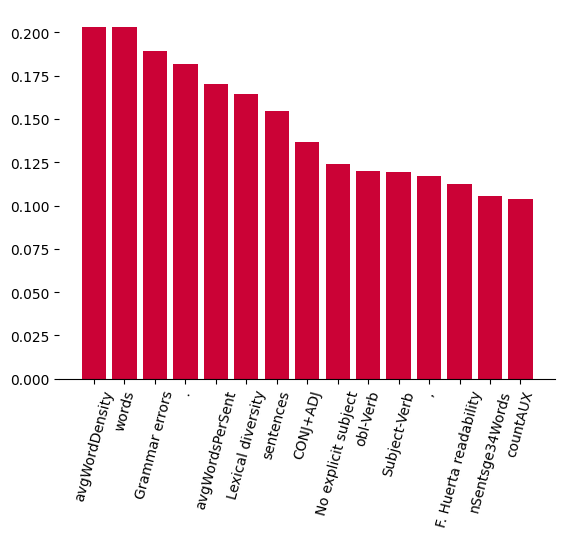

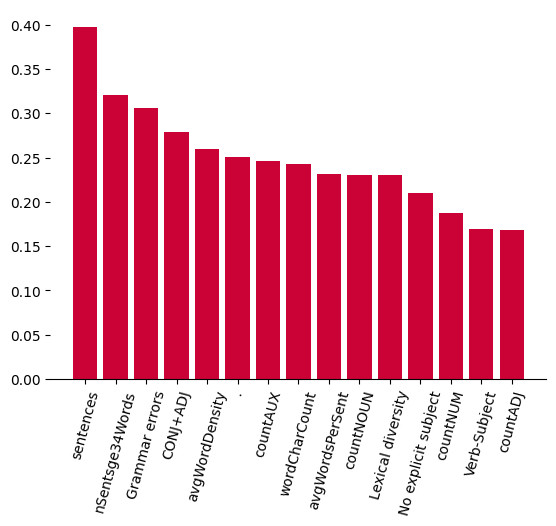

In [4]:
# This dataframe contains the name of each feature as row index and the correlation coefficients (includes p-value of point-biserial) as columns
correlations = pd.DataFrame(columns=["point biserial correlation","p-value", "mutual info"])

for col in df.columns: # Fills the dataframe with the correlation data
    if col not in ("text", "label"):
        correlations.loc[col] = list(pointbiserialr(df["label"], df[col]))+[mutual_info_classif(df[col].to_numpy().reshape((-1, 1)), df["label"])[0]]

# Plots the n most correlated features in a bar graph
n = 15
plotCorrelation(correlations.sort_values(by="mutual info" ,key=lambda v: abs(v), ascending=False)["mutual info"], n)
plotCorrelation(correlations.sort_values(by="point biserial correlation" ,key=lambda v: abs(v), ascending=False)["point biserial correlation"], n)

# Model

Each model in the 'models' list is tested and for each of these each iteration in the nested loop the features used by the model are reduced by one (from the one with the lowest correlation to the one with the highest). Then the iteration of the loop, the list of the features used, the evaluation metrics of the model and a deep copy of the model object are saved as a tuple into a dictionary, which has the models tested as keys and the list of tuples as values. Thus the optimal set of features can be retrieved from the tuple with the highest F1 score.

In [146]:
# The order in which the features will be removed in order to minimize noise
#order_by_coefficient = "point biserial correlation"
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index

In [147]:
maxiters = 100000 #Max iterations for the logistic regression and Support Vector Classification models

# List with the models that will be tested
models = (svm.SVC(max_iter=maxiters), LogisticRegression(max_iter=maxiters), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), naive_bayes.GaussianNB())

# This Dictionary will contain the model name as keys and a list of tuples as values.
# Each tuple contains the number of features that have been removed in index 0, the list of features used in index 1, the evaluation metrics in index 2
# and a deep copy of the model in index 3, which will be used later
models_eval = dict()

for model in models:
  for i in range(len(feature_cols)):
    # Generate train and test data. The data is sampled in a stratified way, taking the same proportion of each label.
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    model.fit(x_train, y_train) # Model training
    y_prediction = model.predict(x_test) # Model prediction for evaluation
    if type(model).__name__ in models_eval.keys(): # Add the features used, evaluation metrics, and deep copy of the model to the dict
      models_eval[type(model).__name__].append((i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model)))
    else: # Create the key if the name of the model hasn't been found
      models_eval[type(model).__name__] = [(i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model))]

In [148]:
best_model = () # Best model used (the deep copy of the model), should point to the index 3 of the tuple
best_f1 = 0 # Here the tuple of the best performing model will be stored
scores = []
for k in models_eval.keys():
  highest = max(models_eval[k], key=lambda x: x[2]["f1"])
  scores.append(highest[2]["f1"])
  print(k, ":", max(models_eval[k], key=lambda x: x[2]["f1"])[2]["f1"])
  if isinstance(best_f1, int) or highest[2]["f1"] > best_f1[2]["f1"]:
    best_f1=highest
    best_model = best_f1[3]

SVC : 0.8759124087591241
LogisticRegression : 0.890625
DecisionTreeClassifier : 0.9384615384615385
RandomForestClassifier : 0.9649805447470817
AdaBoostClassifier : 0.9584905660377359
GaussianNB : 0.9169675090252707


In [149]:
print(f"The model that performed best was {type(best_model).__name__} with an F1 score of {best_f1[2]['f1']} using the following features: \n{best_f1[1]}\nFor a total of {len(best_f1[1])} features.")
print("Its evaluation metrics for language model generated label are:")
for k, v in best_f1[2].items():
  print(f"\t{k}: {v}")
print("For the human written label the metrics are:")
best_prediction_class0 = [0 if i==1 else 1 for i in best_model.predict(np.array(df_gpt[best_f1[1]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[best_f1[1]][int(0.7*len(df_human)):].to_numpy().tolist()))]
for k, v in comparePredict(best_prediction_class0, [0 if i == 1 else 1 for i in y_test], False).items():
  print(f"\t{k}: {v}")

The model that performed best was RandomForestClassifier with an F1 score of 0.9649805447470817 using the following features: 
['avgWordDensity', 'words', 'Grammar errors', '.', 'avgWordsPerSent', 'Lexical diversity', 'sentences', 'CONJ+ADJ', 'No explicit subject', 'obl-Verb', 'Subject-Verb', ',', 'F. Huerta readability', 'nSentsge34Words', 'countAUX', 'Object-Verb', 'nSentsle11Words', 'PRON+VERB', 'CONJ+ADV', 'countNOUN', 'countADJ', 'TTR', 'Lexical density', 'Verb-Object', 'wordCharCount', 'countCCONJ', 'countSCONJ', 'countVERB', 'countPRON', 'G. Polini', 'Verb-Subject', 'CONJ+NOUN', 'NOUN+VERB', 'countADV', 'countADP', 'countPROPN', 'CONJ+VERB', 'countNUM', 'Crawford score', '-', '!', 'ADJ+VERB', ')', '(', 'Superlatives', '$', '"', '\\', ';', 'NERS', '@', '#', '*', 'caps', '+', '€', '?', ':']
For a total of 58 features.
Its evaluation metrics for language model generated label are:
	precision: 0.9763779527559056
	recall: 0.9538461538461539
	accuracy: 0.991
	f1: 0.9649805447470817
Fo

In [151]:
print("Full dataset prediction (I know this is wrong but I like to see high numbers): ")
comparePredict(best_model.predict(df[best_f1[1]].to_numpy()), df["label"].to_numpy())

Full dataset prediction (I know this is wrong but I like to see high numbers): 

          True positives = 420
          True negatives = 2888
          False positives = 2
          False negatives = 5
          Precision = 0.9929245283018868
          Recall = 0.9859484777517564
          Accuracy = 99.72883398614042%
          F1 = 98.94242068155113%
    


{'precision': 0.9929245283018868,
 'recall': 0.9859484777517564,
 'accuracy': 0.9972883398614041,
 'f1': 0.9894242068155112}

# Average best performing model

This next model uses the overall best performing algorithm (Random forest) and the average number of features (41) when that algorithm is the best performing.

In [143]:
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
final_model = ensemble.RandomForestClassifier()
nfeatures = 41
x_train = np.array(df_gpt[feature_cols[:nfeatures]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][:int(0.7*len(df_human))].to_numpy().tolist())
y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
x_test  = np.array(df_gpt[feature_cols[:nfeatures]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][int(0.7*len(df_human)):].to_numpy().tolist())
y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
final_model.fit(x_train, y_train)
y_prediction = final_model.predict(x_test)
comparePredict(y_prediction, y_test)


          True positives = 122
          True negatives = 866
          False positives = 2
          False negatives = 6
          Precision = 0.9761904761904762
          Recall = 0.9461538461538461
          Accuracy = 99.0%
          F1 = 96.09375%
    


{'precision': 0.9761904761904762,
 'recall': 0.9461538461538461,
 'accuracy': 0.99,
 'f1': 0.9609375}

# Save Model

In [145]:
import pickle
# Save the model into a pickle file
with open('Classifier.pkl','wb') as f:
    pickle.dump(best_model,f)

# Everything below this is for testing purposes, to make plots or export info to excel

In [54]:
# General test for all models is repeated 40 times in order to get consistent data
iterations = 40
for num in range(1):
  df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/test.xlsx', header=0, index_col=0) # Read an excel from the path. The path written to work with my drive in google colab

  df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

  # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
  df_gpt = df[df["label"] == 1]
  df_human = df[df["label"] == 0]
  maxiters = 100000 #Max iterations for the logistic regression and Support Vector Classification models

  # List with the models that will be tested
  models = (svm.SVC(max_iter=maxiters), LogisticRegression(max_iter=maxiters), tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), ensemble.AdaBoostClassifier(), naive_bayes.GaussianNB())

  # This Dictionary will contain the model name as keys and a list of tuples as values.
  # Each tuple contains the number of features that have been removed in index 0, the list of features used in index 1, the evaluation metrics in index 2
  # and a deep copy of the model in index 3, which will be used later
  models_eval = dict()
  for model in models:
    for i in range(len(feature_cols)):
      # Generate train and test data. The data is sampled in a stratified way, taking the same proportion of each label.
      x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
      y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
      x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
      y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
      model.fit(x_train, y_train) # Model training
      y_prediction = model.predict(x_test) # Model prediction for evaluation
      if type(model).__name__ in models_eval.keys(): # Add the features used, evaluation metrics, and deep copy of the model to the dict
        models_eval[type(model).__name__].append((i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model)))
      else: # Create the key if the name of the model hasn't been found
        models_eval[type(model).__name__] = [(i, list(feature_cols[:len(feature_cols)-i]), comparePredict(y_prediction, y_test, False), deepcopy(model))]
  best_model = () # Best model used (the deep copy of the model), should point to the index 3 of the tuple
  best_f1 = 0 # Here the tuple of the best performing model will be stored
  scores = []
  for k in models_eval.keys():
    highest = max(models_eval[k], key=lambda x: x[2]["f1"])
    scores.append(highest[2]["f1"])
    if isinstance(best_f1, int) or highest[2]["f1"] > best_f1[2]["f1"]:
      best_f1=highest
      best_model = best_f1[3]
  try:
    df_algorithms = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/Algorithms.xlsx', header=0, index_col=0)
  except:
    df_algorithms = pd.DataFrame(index=list(models_eval.keys()))

  df_algorithms[len(df_algorithms.columns)+1] = pd.Series(scores, index=df_algorithms.index)
  df_algorithms.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/Algorithms.xlsx", engine="openpyxl")

  try:
    df_features = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python/TFG/FeaturesUsed.xlsx', header=0, index_col=0)
  except:
    df_features = pd.DataFrame(index=["nfeatures", "model"])

  df_features[len(df_features.columns)+1] = pd.Series([len(best_f1[1]), type(best_model).__name__], index=df_features.index)
  df_features.to_excel("/content/drive/MyDrive/Colab Notebooks/Python/TFG/FeaturesUsed.xlsx", engine="openpyxl")

In [137]:
# Testing what seems to be the optimal set of features in the most consistent order with the best performing algorithm
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
final_model_f1 = []
nfeatures = 41
iterations = 300
for i in range(iterations):
  df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

  # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
  df_gpt = df[df["label"] == 1]
  df_human = df[df["label"] == 0]
  final_model = ensemble.RandomForestClassifier()
  x_train = np.array(df_gpt[feature_cols[:nfeatures]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][:int(0.7*len(df_human))].to_numpy().tolist())
  y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
  x_test  = np.array(df_gpt[feature_cols[:nfeatures]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:nfeatures]][int(0.7*len(df_human)):].to_numpy().tolist())
  y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
  final_model.fit(x_train, y_train)
  y_prediction = final_model.predict(x_test)
  final_model_f1.append(comparePredict(y_prediction, y_test, False)["f1"])

print(f"Average F1 score out of {iterations} samples of the {type(final_model).__name__} using {nfeatures} features: {sum(final_model_f1)/len(final_model_f1)}")

Average F1 score out of 300 samples of the RandomForestClassifier using 41 features: 0.9586313669724008


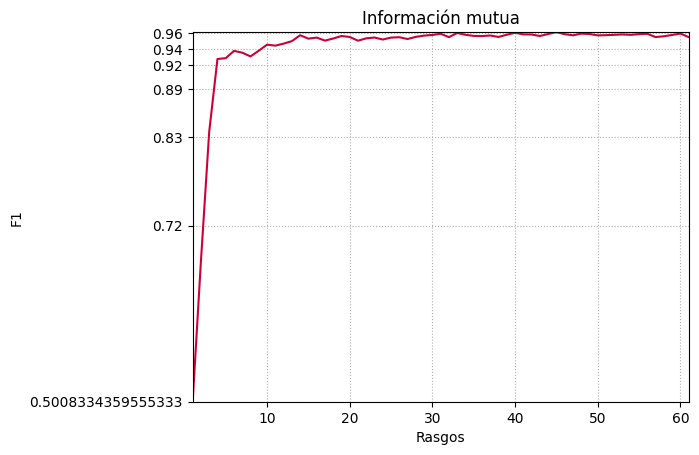

In [127]:
# Plotting the average F1 given the number of features in mutual info order
order_by_coefficient = "mutual info"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
f1_dict_mi = {}
iterations = 40
for j in range(iterations):
  for i in range(len(feature_cols)):
    df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

    # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
    df_gpt = df[df["label"] == 1]
    df_human = df[df["label"] == 0]
    final_model = ensemble.RandomForestClassifier()
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    final_model.fit(x_train, y_train)
    y_prediction = final_model.predict(x_test)
    if len(feature_cols[:len(feature_cols)-i]) in f1_dict_mi.keys():
      f1_dict_mi[len(feature_cols[:len(feature_cols)-i])].append(comparePredict(y_prediction, y_test, False)["f1"])
    else:
      f1_dict_mi[len(feature_cols[:len(feature_cols)-i])] = [comparePredict(y_prediction, y_test, False)["f1"]]
for k in f1_dict_mi.keys():
  f1_dict_mi[k] = sum(f1_dict_mi[k])/iterations
plotGraph(f1_dict_mi.keys(), f1_dict_mi.values(), "Información mutua", nticks=7)

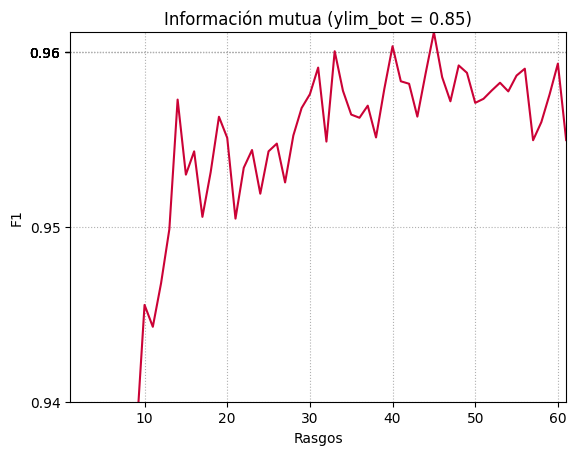

Standard deviation of values over 0.94 is  0.0035759937713230583
Average:  0.9557088168328989


In [133]:
# Plotting the average F1 given the number of features in mutual info order but zooming to the upper bound
plotGraph(f1_dict_mi.keys(), f1_dict_mi.values(), "Información mutua (ylim_bot = 0.85)", nticks=7, ylim_bot=0.94)
print("Standard deviation of values over 0.94 is ", np.std([i for i in f1_dict_mi.values() if i >= 0.94]))
print("Average: ", np.average([i for i in f1_dict_mi.values() if i >= 0.94]))

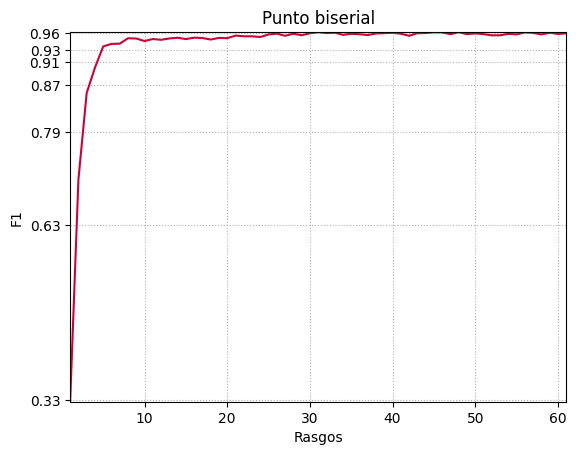

In [113]:
# Plotting the average F1 given the number of features in point biserial order
order_by_coefficient = "point biserial correlation"
feature_cols = correlations.sort_values(by=order_by_coefficient ,key=lambda v: abs(v), ascending=False)[order_by_coefficient].index
f1_dict = {}
iterations = 40
for j in range(iterations):
  for i in range(len(feature_cols)):
    df = df.sample(frac=1).reset_index(drop=True) # Shuffles the dataframe

    # DataFrames containing the stratified data (label 1 for AI generated and label 0 got human generated texts)
    df_gpt = df[df["label"] == 1]
    df_human = df[df["label"] == 0]
    final_model = ensemble.RandomForestClassifier()
    x_train = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][:int(0.7*len(df_human))].to_numpy().tolist())
    y_train = np.array(df_gpt["label"][:int(0.7*len(df_gpt))].to_numpy().tolist() + df_human["label"][:int(0.7*len(df_human))].to_numpy().tolist())
    x_test  = np.array(df_gpt[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human[feature_cols[:len(feature_cols)-i]][int(0.7*len(df_human)):].to_numpy().tolist())
    y_test  = np.array(df_gpt["label"][int(0.7*len(df_gpt)):].to_numpy().tolist() + df_human["label"][int(0.7*len(df_human)):].to_numpy().tolist())
    final_model.fit(x_train, y_train)
    y_prediction = final_model.predict(x_test)
    if len(feature_cols[:len(feature_cols)-i]) in f1_dict.keys():
      f1_dict[len(feature_cols[:len(feature_cols)-i])].append(comparePredict(y_prediction, y_test, False)["f1"])
    else:
      f1_dict[len(feature_cols[:len(feature_cols)-i])] = [comparePredict(y_prediction, y_test, False)["f1"]]
for k in f1_dict.keys():
  f1_dict[k] = sum(f1_dict[k])/iterations
plotGraph(f1_dict.keys(), f1_dict.values(), "Punto biserial", nticks=7)

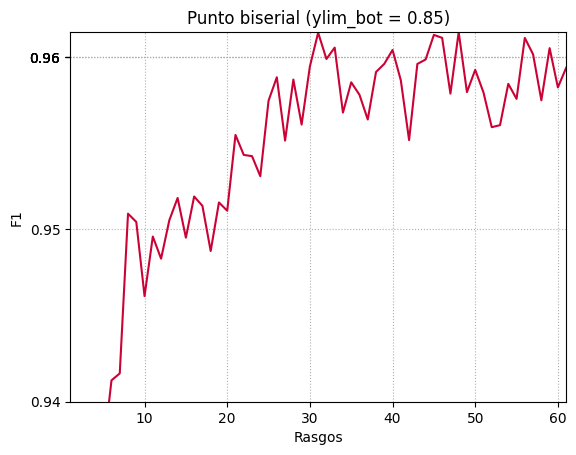

Standard deviation of values over 0.94 is  0.004807633386817659
Average:  0.9557708552767438


In [134]:
# Plotting the average F1 given the number of features in point biserial order but zooming to the upper bound
plotGraph(f1_dict.keys(), f1_dict.values(), "Punto biserial (ylim_bot = 0.85)", ylim_bot=0.94)
print("Standard deviation of values over 0.94 is ", np.std([i for i in f1_dict.values() if i >= 0.94]))
print("Average: ", np.average([i for i in f1_dict.values() if i >= 0.94]))